In [ ]:
pip install --upgrade tensorflow

In [ ]:
pip install Keras

In [15]:
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 1.15.0


In [16]:
import os
import shutil

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from tensorflow import keras
import numpy as np
import os

In [18]:
global graph

graph = tf.get_default_graph()

In [19]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Activation
import numpy as np
from keras import backend as K

In [35]:
K.clear_session()

In [20]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16

NUM_CLASSES = 2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder_26:0", shape=(3, 3, 3, 64), dtype=float32) is not an element of this graph.

In [7]:
for layer in model.layers[0:20]:
    layer.trainable = False

In [8]:
from tensorflow.data import Dataset

In [9]:
NUM_CLASSES = 2

# This function takes image paths as arguments and reads corresponding images
def input_parser(img_path, label):
    # convert the label to one-hot encoding
    one_hot = tf.one_hot(label, NUM_CLASSES)
    # read the img from file and decode it using tf
    img_file = tf.read_file(img_path)
    img_decoded = tf.image.decode_jpeg(img_file, channels=3, name="decoded_images")
    return img_decoded, one_hot

# This function takes image and resizes it to smaller format (150x150)
def image_resize(images, labels):
    # Be very careful with resizing images like this and make sure to read the doc!
    # Otherwise, bad things can happen - https://hackernoon.com/how-tensorflows-tf-image-resize-stole-60-days-of-my-life-aba5eb093f35
    resized_image = tf.image.resize_images(images, (300, 300), align_corners=True)
    resized_image_asint = tf.cast(resized_image, tf.int32)
    return resized_image_asint, labels

In [10]:
# Execution plan is defined here.
# Since it uses lazy evaluation, the images will not be read after calling build_pipeline_plan()
# We need to use iterator defined here in tf context
def build_pipeline_plan(img_paths, labels, batch_size):

    # We build a tensor of image paths and labels
    tr_data = Dataset.from_tensor_slices((img_paths, labels))
    # First step of input pipeline - read images in paths as jpegs
    tr_data_imgs = tr_data.map(input_parser)
    # Apply resize to each image in the pipeline
    tr_data_imgs = tr_data_imgs.map(image_resize)
    # Gives us opportuinty to batch images into small groups
    tr_dataset = tr_data_imgs.batch(batch_size)
    # create TensorFlow Iterator object directly from input pipeline
    iterator = tr_dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    return next_element

# Function to execute defined pipeline in Tensorflow session
def process_pipeline(next_element):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # get each element of the training dataset until the end is reached
        # in our case only one iteration since we read everything as 1 batch
        # can be multiple iterations if we decrease BATCH_SIZE to eg. 10
        images = []
        labels_hot = []
        while True:
            try:
                elem = sess.run(next_element)
                images = elem[0]
                labels_hot = elem[1]
            except tf.errors.OutOfRangeError:
                print("Finished reading the dataset")
                return images, labels_hot

In [11]:

def get_labeled_files(folder):
    x = []
    y = []
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['0']:
                label = 0
            elif folderName in ['1']:
                label = 1
            else:
                label = 2
                continue # we do not investigate other dirs
            for image_filename in os.listdir(folder + folderName):
                img_path = folder + folderName + '/' + image_filename
                if img_path is not None and str.endswith(img_path, 'png'):
                    x.append(img_path)
                    y.append(label)
    
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

In [12]:
def load_dataset(path, batch_size):
    tf.reset_default_graph()
    files, labels = get_labeled_files(path)
    p = tf.constant(files, name="train_imgs")
    l = tf.constant(labels, name="train_labels")
    
    next_element = build_pipeline_plan(p, l, batch_size=batch_size)
    imgs, labels = process_pipeline(next_element)
    return imgs, labels

In [13]:
x_train, y_train = load_dataset("Data01/All/All_Raw/Train/", 6000)



Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


KeyboardInterrupt: 

In [17]:
print(x_train.shape)
print(y_train.shape)

(450, 300, 300, 3)
(450, 2)


In [18]:
#tf.keras.backend.clear_session()

In [19]:
with graph.as_default():

    optimizer = keras.optimizers.RMSprop()

    model.compile(loss='categorical_crossentropy',     
                  optimizer=optimizer, 
                  metrics=['accuracy'])

#model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
with graph.as_default():

    history = model.fit(
        x=x_train, y=y_train,
        validation_split=0.2,
        shuffle=True,
        batch_size=64,
        epochs=10,
        verbose=1
    )





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 360 samples, validate on 90 samples
Epoch 1/10
360/360 [==============================] - 94s 261ms/step - loss: 7.3788 - acc: 0.5250 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/10
360/360 [==============================] - 139s 387ms/step - loss: 6.7147 - acc: 0.5778 - val_loss: 7.7879 - val_acc: 0.5111
Epoch 3/10
360/360 [==============================] - 165s 459ms/step - loss: 4.9130 - acc: 0.6833 - val_loss: 1.0710 - val_acc: 0.9333
Epoch 4/10
360/360 [==============================] - 162s 451ms/step - loss: 3.6821 - acc: 0.7556 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/10
360/360 [==============================] - 166s 460ms/step - loss: 4.7745 - acc: 0.6972 - val_loss: 7.2433 - val_acc: 0.5333
Epoch 6/10
360/360 [==============================] - 120s 332ms/step - loss: 2.6197 - acc: 0.8306 - val_loss: 4.3519 - val_acc: 0.7222
Epoch 7/10
360/360 [===============

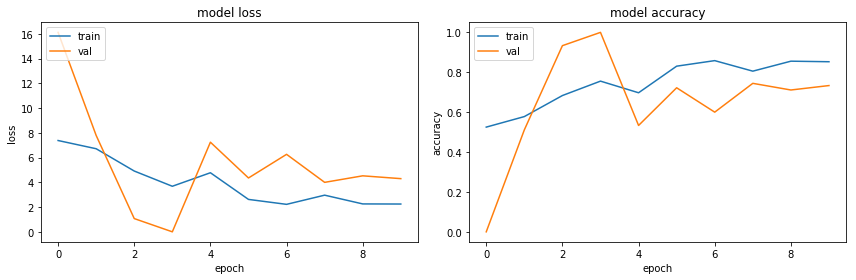

In [22]:
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    
plot_learning_curves(history)

In [23]:

idx = np.argmin(history.history['val_loss']) 
#model.load_weights("model/weights.epoch_{:02d}.hdf5".format(idx + 1))

print("Loading the best model")
print("epoch: {}, val_loss: {}, val_acc: {}".format(idx + 1, history.history['val_loss'][idx], history.history['val_acc'][idx]))

Loading the best model
epoch: 4, val_loss: 1.1920928955078125e-07, val_acc: 1.0


In [24]:
x_test, y_test = load_dataset("Data01/All/All_Raw/Test/", 6000)

Finished reading the dataset


In [25]:
print(x_test.shape)
print(y_test.shape)

(212, 300, 300, 3)
(212, 2)


In [27]:

score = model.evaluate(x_test, y_test, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 2.760266951794894, Accuracy: 0.8254716981132075


In [28]:
from sklearn.metrics import confusion_matrix
from model_diag import plot_confusion_matrix

y_pred = model.predict(x_test)
# to get the prediction, we pick the class with with the highest probability
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, target_names = ['0', '1'], normalize=False)

ModuleNotFoundError: No module named 'model_diag'

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('Convolutional_Neural_Networks/dataset/test_set/cats/cat.4879.jpg', target_size = (128,128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices
print(result)
# if result[0][0] <= 0.5:
#     prediction = 'cat'
# else:
#     prediction = 'dog'
# print(prediction)


In [ ]:
print(training_set.class_indices)